In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import make_grid
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_dataset = MNIST(root='./content', train=True, download=True, 
                      transform=transforms.ToTensor())
test_dataset = MNIST(root='./content', train=False, download=True,
                     transform=transforms.ToTensor())

In [3]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder network
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc21 = nn.Linear(256, 20)
        self.fc22 = nn.Linear(256, 20)

        # Decoder network
        self.fc3 = nn.Linear(20, 256)
        self.fc4 = nn.Linear(256, 64 * 7 * 7)
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1)

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        mu = self.fc21(x)
        logvar = self.fc22(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = Variable(torch.randn(std.size()).cuda())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        z = F.relu(self.fc3(z))
        z = F.relu(self.fc4(z))
        z = z.view(z.size(0), 64, 7, 7)
        z = F.relu(self.deconv1(z))
        z = torch.sigmoid(self.deconv2(z))
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        z = self.decode(z)
        return z, mu, logvar

In [9]:
def train_batch(data,model,optimizer,loss_function):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()
    recon_batch, mean, log_var = model(data)
    loss,mse,kld = loss_function(recon_batch, data, mean, log_var)
    loss.backward()
    optimizer.step()
    return loss, mse, kld, log_var.mean(), mean.mean()

@torch.no_grad()
def validate_batch(data,model,loss_function):
    model.eval()
    data = data.to(device)
    recon,mean,log_var = model(data)
    loss, mse, kld = loss_function(recon,data,mean,log_var)
    return loss, mse, kld, log_var.mean(), mean.mean()

In [10]:
def loss_function(recon_x, x, mean, log_var):
    RECON = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1+log_var-mean.pow(2) - log_var.exp())
    return RECON + KLD, RECON, KLD

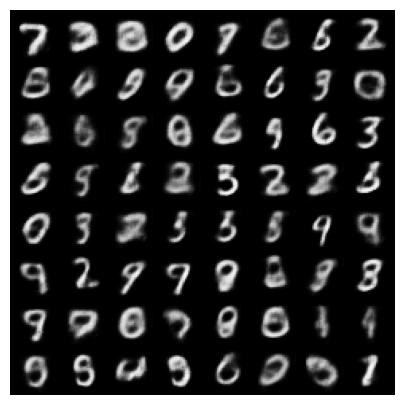

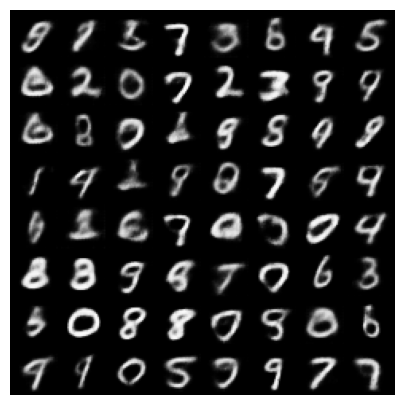

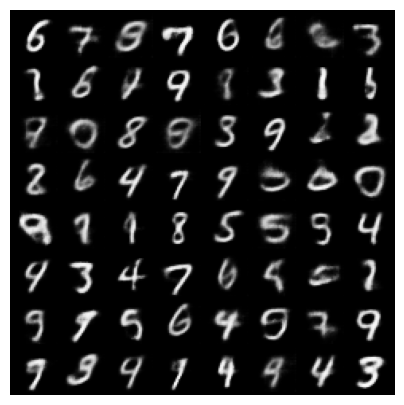

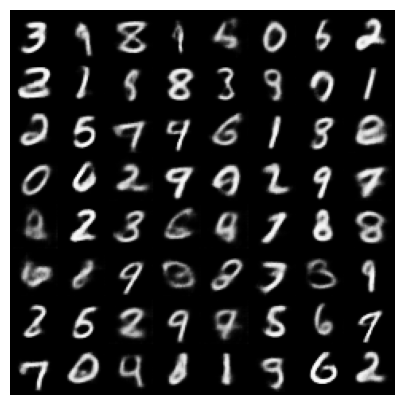

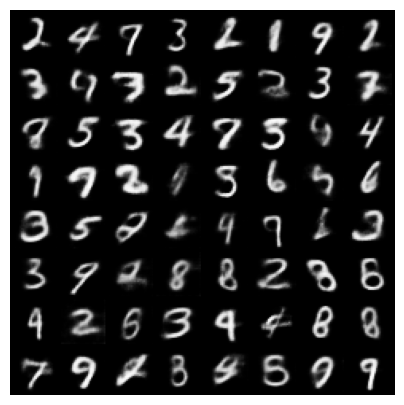

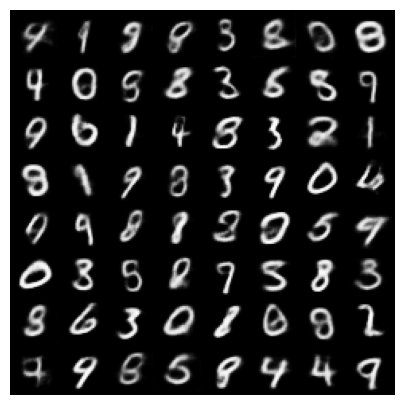

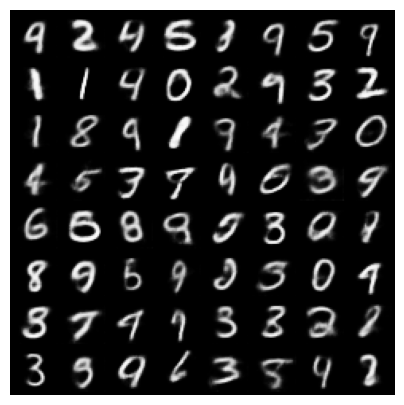

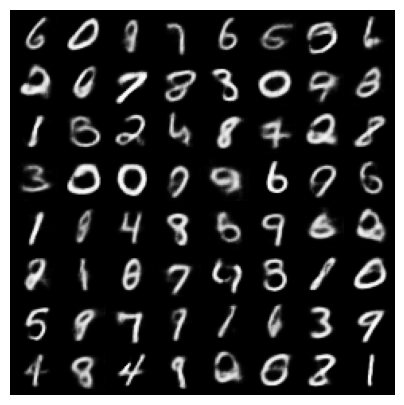

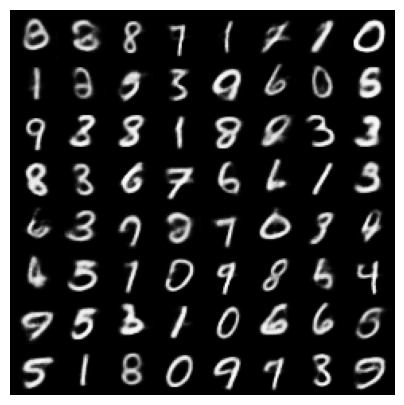

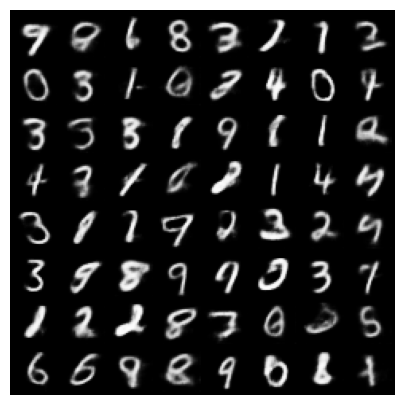

In [11]:
# Defina o dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Criação do modelo e movendo para o dispositivo
vae = VAE().to(device)
optimizer = optim.AdamW(vae.parameters(), lr=1e-3)
n_epochs = 10
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    N = len(train_loader)
    for batch_idx, (data, _) in enumerate(train_loader):
        loss, recon, kld, log_var, mean = train_batch(data, vae, optimizer, loss_function)
        pos = epoch + (1 + batch_idx) / N
        train_losses.append(loss.item())

    N = len(test_loader)
    for batch_idx, (data, _) in enumerate(test_loader):
        loss, recon, kld, log_var, mean = validate_batch(data, vae, loss_function)
        pos = epoch + (1 + batch_idx) / N
        val_losses.append(loss.item())

    with torch.no_grad():
        z = torch.randn(64, 20).to(device)
        sample = vae.decode(z).to(device)
        images = make_grid(sample.view(64, 1, 28, 28)).permute(1, 2, 0)
        show(images)